## Lista 4
Aluno: Álvaro de Carvalho Alves

# Questão 1

O Objetivo desta questão é adquirir experiência com o algoritmo Erpectation Marimization (EM).
Para isso você deve implementar a sua solução, que deverá estar bem explicada. (Não entre em
pânico, a implementação é simples, e pode ser feita facilmente em Octave, R, Python, etc.)
O dataset fornecido contém o resultado de uma votação de mil usuários em 5 tipos de filmes. (Ao
invés de filmes poderíamos ter candidatos a uma eleição ou outras features. O significado das features
depende do problema, obviamente. Cada um dos usuários vota que acordo com o seu interesse um um
tipo de filme, por exemplo, filmes de Ação, Comédia, Romance, Suspense e Ficção Científica. Cada
usuário dá uma nota de 1 a 4 para cada tipo de filme (ou feature) onde 1 significa "não gosto" e 4
"gosto muito"
O objetivo é verificar se é possível classificar os usuários usando 2 classes. Para isso você escolhe o
modelo Naive Bayes pela simplicidade. Deverá ser usado o algoritmo EM para essa tarefa.

#### Importação dos dados

In [1]:
import pandas as pd
import numpy as np

features = ['X1', 'X2', 'X3', 'X4', 'X5']
users = pd.read_csv('lista4-data_scores.csv', 
                       comment='#', 
                       names=features, 
                       sep=' ').reset_index(drop=True)
n_features = 5
n_samples = 1000

users.head(7)

,X1,X2,X3,X4,X5
0,3,1,2,3,3
1,3,1,3,3,3
2,4,4,2,3,1
3,1,1,3,2,3
4,4,4,3,2,1
5,1,2,4,4,4
6,1,1,1,4,4


In [2]:
# ocorrências de cada valor por feature
pd.DataFrame({
    'X1': users['X1'].value_counts(normalize=True),
    'X2': users['X2'].value_counts(normalize=True),
    'X3': users['X3'].value_counts(normalize=True),
    'X4': users['X4'].value_counts(normalize=True),
    'X5': users['X5'].value_counts(normalize=True)
})

,X1,X2,X3,X4,X5
1,0.292,0.304,0.283,0.396,0.419
2,0.138,0.127,0.331,0.167,0.153
3,0.234,0.238,0.192,0.177,0.165
4,0.336,0.331,0.194,0.260,0.263


## a) Quantos parâmetros deverão ser estimados para o modelo Naive Bayes a ser construído?


O objetivo do Naive Bayes é estimar a posterior:

$$
P\left(C=d \mid x_1, x_2, x_3, x_4, x_5\right)=\frac{P\left(x_1, x_2, x_3, x_4, x_5 \mid C=d\right) P(C=d)}{P\left(x_1, x_2, x_3, x_4, x_5\right)}
$$


Sejam $C$, $d_j$, $X_{i}$ e $x_{ij}$ a label para a classe de uma amostra, o identificador da classe da amostra j, a feature i e o valor da feature i da amostra j, respectivamente. Vamos condensar a notação usando:

$$
P\left(C = d_j\right) = P\left(C\right)
$$
$$
P\left(X_{1}=x_{1j}, \cdots, X_{5}=x_{5j}\right) = P\left(\vec{x}\right)
$$
$$
P\left(X_{1}=x_{1j}, \cdots, X_{5}=x_{5j} \mid C = d_j \right) = P\left(\vec{x} \mid C\right)
$$
$$
P\left(C = d_j \mid X_{1}=x_{1j}, \cdots, X_{5}=x_{5j} \right) = P\left(C \mid \vec{x}\right)
$$
$$
P\left(X_{i}=x_{ij} \mid C = d_j  \right) = P\left(X_{i}\mid C\right )
$$

Logo, a posterior fica:

$$
P\left(C \mid \vec{x}\right) = \frac{P\left(\vec{x} \mid C\right) \cdot P\left(C\right)}{P\left(\vec{x}\right)}
$$

Neste caso, temos 5 features $X_i$, que podem assumir 4 valores $x_{ij} \in \{1,2,3,4\}$, e 2 classes $d_j \in \{1,2\}$. Usando a premissa do Naive Bayes
de que as features são independentes condicionadas pela classe, a posterior será:


$$
P\left(C \mid \vec{x}\right) = \frac{\prod_{i=1}^5 P\left(X_{i} \mid C\right) \cdot P\left(C\right)}
{\prod_{i=1}^5 P\left(X_{i} \mid C = 1\right) P\left(C = 1\right) + \prod_{i=1}^5 P\left(X_{i} \mid C = 2\right) P\left(C = 2\right)}
$$

Portanto, para calcular o número de parâmetros, precisamos obter a 
probabilidade de cada valor (4 possibilidades) em cada feature 
(5 possibilidades) condicionada por cada classe (2 possibilidades). Mas como a probabilidade em cada feature, condicionada por classe, tem de somar um, só precisamos saber 3 das 4 probabilidades e a quarta é obtida automaticamente. Logo, temos 3x5x2 = 30 parâmetros.

Além disso precisamos da probabilidade de cada classe. Como só temos duas
classes: P(C=2) = 1 - P(C=1), então temos um parâmetro adicional. **Portanto, no total, teremos 31 parâmetros a serem estimados.**




## b) Explique as equações usadas para resolver o problema.


Para treinar o modelo, precisamos achar os parâmetros que maximizem a
likelihood, usando o algoritmo EM.

<!-- Inicialização:
Podemos inicializar cada parâmetro com um valor arbitrário. Iniciarei todos
com 0.5.

$$
P\left(C=1 \right)^{(0)} = 0,5
$$
$$
P\left(C=2 \right)^{(0)} = 1 - P\left(C=1 \right)^{(0)} = 0,5
$$
$$
P\left(X_{i} = x_q\mid C = 1 \right)^{(0)} = \frac{1}{4}
$$
$$
P\left(X_{i} = x_q\mid C = 2 \right)^{(0)} = \frac{1}{4}
$$

Para todas as 5 features $X_i$ e seus possíveis valores $x_q$ entre 1 e 4.


Agora, para começar as iterações do algoritmos, teremos os passos:

**E step:** Calcular a posterior, baseada nos parâmetros que definimos, para cada amostra k
$$
P^{(0)}\left(C = 1 \mid \vec{x}_k\right) = \frac{\frac{1}{4}^5 \cdot 0,5}{\frac{1}{4}^5 \cdot 0,5 + \frac{1}{4}^5 \cdot 0,5} = 0,5
$$

$$
P^{(0)}\left(C = 2 \mid \vec{x}_k\right)= 1 -P^{(0)}\left(C = 1 \mid \vec{x}_k\right) = 0,5
$$

**M step:** Atualizar os parâmetros, baseados na posterior
$$
 P^{(1)}\left(C = 1\right) =
 \frac{1}{1000} \cdot \sum_{k=1}^{1000} P^{(0)}\left(C = 1 \mid \vec{x}_k\right) = 0,5
$$
$$
 P^{(1)}\left(C = 2\right) =
 \frac{1}{1000} \cdot \sum_{k=1}^{1000} P^{(0)}\left(C = 2 \mid \vec{x}_k\right) = 0,5
$$
$$
P^{(1)}\left(X_{i}=x_{q} \mid C = 1\right) = 
\frac{\sum_{k=1}^{1000} P^{(0)}\left(C = 1 \mid X_{i}=x_{ik}\right) \cdot \mathbb{1}\left(X_{i}=x_{q}\right)}
{\sum_{k=1}^{1000} P^{(0)}\left(C=1 \mid X_{i}=x_{ik}\right)}
$$

$$
P^{(1)}\left(X_{i}=x_{q} \mid C = 2\right) =
\frac{\sum_{k=1}^{1000} P^{(0)}\left(C = 2 \mid X_{i}=x_{ik}\right) \cdot \mathbb{1}\left(X_{i}=x_{q}\right)}
{\sum_{k=1}^{1000} P^{(0)}\left(C = 2 \mid X_{i}=x_{ik}\right)}
$$

Para todos $i \in \{1, 2, 3, 4, 5\}$ e $x_q \in \{1,2,3,4\}$ -->


Para isso, iteraremos os passos E e M até a convergência:

#### E step:

Calcular a responsabilidade de cada classe sobre cada usuário $k$:
$$
P^{(t)}\left(C = 1 \mid \vec{x}_k\right) =
\frac{\prod_{i=1}^5 P^{(t)}\left(X_{i} = x_{ik} \mid C = 1\right) \cdot P^{(t)}\left(C = 1\right)}
{\prod_{i=1}^5 P^{(t)}\left(X_{i} = x_{ik} \mid C = 1\right) P^{(t)}\left(C = 1\right) + \prod_{i=1}^5 P^{(t)}\left(X_{i} = x_{ik} \mid C = 2\right) P^{(t)}\left(C = 2\right)}
$$

$$
P^{(t)}\left(C = 2 \mid \vec{x}_k\right) = 1 - P^{(t)}\left(C = 1 \mid \vec{x}_k\right)
$$

#### M step:
$$
 P^{(t+1)}\left(C = 1 \right) = \frac{1}{1000} \cdot \sum_{k=1}^{1000} P^{(t)}\left(C = 1 \mid \vec{x}_k\right)
$$

$$
P^{(t+1)}\left(C = 2 \right) = 1 - P^{(t+1)}\left(C = 1 \right)
$$

$$
P^{(t+1)}\left(X_{i}=x_{q} \mid C = 1\right) = 
\frac{\sum_{k=1}^{1000} P^{(t)}\left(C = 1 \mid \vec{x}_k\right) \cdot \mathbb{1}\left(X_{i}=x_{q}\right)}
{\sum_{k=1}^{1000} P^{(t)}\left(C = 1 \mid \vec{x}_k\right)}
$$

$$
P^{(t+1)}\left(X_{i}=x_{q} \mid C = 2\right) =
\frac{\sum_{k=1}^{1000} P^{(t)}\left(C = 2 \mid \vec{x}_k\right) \cdot \mathbb{1}\left(X_{i}=x_{q}\right)}
{\sum_{k=1}^{1000} P^{(t)}\left(C = 2 \mid \vec{x}_k\right)}
$$


Para todos $i \in \{1, 2, 3, 4, 5\}$ e $x_q \in \{1,2,3,4\}$


## c) Baseado no item anterior, explique a sua implementação, incluindo as suas escolhas para a inicialização do código.


### Inicialização dos parâmetros:

Para inicializar as priors
$$
P^{(0)}\left(C=1 \right)
$$
$$
P^{(0)}\left(C=2 \right) = 1 - P^{(0)}\left(C=1 \right)
$$

Farei ``prior_class_1 = 0.5`` e ``prior_class_2 = 1 - prior_class_1``.

In [3]:
prior_class_1_ini = 0.5 
prior_class_2_ini = 1 - prior_class_1_ini

Já, para as equações as condicionais:
$$
P^{(0)}\left(X_{i} = x_q\mid C = 1 \right)
$$
$$
P^{(0)}\left(X_{i} = x_q\mid C = 2 \right)
$$

Precisamos dessas probabilidades para cada $x_q \in \{1,2,3,4\}$ e $i \in \{1,2,3,4,5\}$.

Para isso, usarei duas matrizes ``prob_x_given_class_1`` e ``prob_x_given_class_2``. Uma para cada classe. Onde cada coordenada $n, m$ representa a probabilidade de se obter o valor $n+1$ para a feature $m+1$.

A inicialização será feita com a função ``np.random.dirichlet``, que retorna uma matriz 5x4 cujas linhas são distribuições de Dirichlet que somam um, logo farei a transposta para ficar com uma matriz 4x5, cujas colunas somam um. 

In [4]:
prob_x_given_class_1_ini = np.random.dirichlet(np.ones(4), size=5).T
prob_x_given_class_2_ini = np.random.dirichlet(np.ones(4), size=5).T
prob_x_given_class_1_ini

array([[0.65313679, 0.13866766, 0.61760424, 0.10344626, 0.16093404],
       [0.08192364, 0.68405627, 0.00681957, 0.61808081, 0.09267141],
       [0.08381178, 0.16885146, 0.2846907 , 0.17844074, 0.15615262],
       [0.18112779, 0.00842462, 0.09088548, 0.10003219, 0.59024193]])

### E step: Calcular a responsabilidade de cada classe sobre cada usuário $k$



$$
P^{(t)}\left(C = 1 \mid \vec{x}_k\right) =
\frac{\prod_{i=1}^5 P^{(t)}\left(X_{i} = x_{ik} \mid C = 1\right) \cdot P^{(t)}\left(C = 1\right)}
{\prod_{i=1}^5 P^{(t)}\left(X_{i} = x_{ik} \mid C = 1\right) P^{(t)}\left(C = 1\right) + \prod_{i=1}^5 P^{(t)}\left(X_{i} = x_{ik} \mid C = 2\right) P^{(t)}\left(C = 2\right)}
$$

$$
P^{(t)}\left(C = 2 \mid \vec{x}_k\right) = 1 - P^{(t)}\left(C = 1 \mid \vec{x}_k\right)
$$


In [5]:
def evaluate_posteriors(users, prob_x_given_class_1, prior_class_1, prob_x_given_class_2, prior_class_2):
    posterior_class_1 = np.zeros(n_samples)
    
    for k in range(n_samples):
        prob_xk_1 = np.prod([prob_x_given_class_1[users.iloc[k,i]-1,i] for i in range(n_features)])
        prob_xk_2 = np.prod([prob_x_given_class_2[users.iloc[k,i]-1,i] for i in range(n_features)])
    
        posterior_class_1[k] = prob_xk_1 * prior_class_1 / (prob_xk_1 * prior_class_1 + prob_xk_2 * prior_class_2)

    return posterior_class_1, np.ones(n_samples) - posterior_class_1

In [6]:
posterior_class_1_ini, posterior_class_2_ini = evaluate_posteriors(users, prob_x_given_class_1_ini, prior_class_1_ini, prob_x_given_class_2_ini, prior_class_2_ini)

### M step: Atualizar os parâmetros, baseados na posterior
$$
 P^{(t+1)}\left(C = 1 \right) = \frac{1}{1000} \cdot \sum_{k=1}^{1000} P^{(t)}\left(C = 1 \mid \vec{x}_k\right)
$$

$$
P^{(t+1)}\left(C = 2 \right) = 1 - P^{(t+1)}\left(C = 1 \right)
$$

$$
P^{(t+1)}\left(X_{i}=x_{q} \mid C = 1\right) = 
\frac{\sum_{k=1}^{1000} P^{(t)}\left(C = 1 \mid \vec{x}_k\right) \cdot \mathbb{1}\left(X_{i}=x_{q}\right)}
{\sum_{k=1}^{1000} P^{(t)}\left(C = 1 \mid \vec{x}_k\right)}
$$

$$
P^{(t+1)}\left(X_{i}=x_{q} \mid C = 2\right) =
\frac{\sum_{k=1}^{1000} P^{(t)}\left(C = 2 \mid \vec{x}_k\right) \cdot \mathbb{1}\left(X_{i}=x_{q}\right)}
{\sum_{k=1}^{1000} P^{(t)}\left(C = 2 \mid \vec{x}_k\right)}
$$


Para todos $i \in \{1, 2, 3, 4, 5\}$ e $x_q \in \{1,2,3,4\}$

In [7]:
def evaluate_priors(posterior_class_1):
    prior_class_1 = posterior_class_1.mean()
    return prior_class_1, 1 - prior_class_1

def evaluate_conditionals(users, posterior_class_1, posterior_class_2):
    prob_x_given_class_1 = np.zeros((4,5))
    prob_x_given_class_2 = np.zeros((4,5))
    
    for i in range(n_features):
        for x_q in (1, 2, 3, 4):
            weighted_count_posterior_class_1 = posterior_class_1 @ (users.iloc[:,i] == x_q)
            weighted_count_posterior_class_2 = posterior_class_2 @ (users.iloc[:,i] == x_q)
    
            prob_x_given_class_1[x_q-1, i] = weighted_count_posterior_class_1 / sum(posterior_class_1)
            prob_x_given_class_2[x_q-1, i] = weighted_count_posterior_class_2 / sum(posterior_class_2)

    return prob_x_given_class_1, prob_x_given_class_2

In [8]:
prior_class_1_ini, prior_class_2_ini = evaluate_priors(posterior_class_1_ini)

prob_x_given_class_1_ini, prob_x_given_class_2_ini = evaluate_conditionals(users, posterior_class_1_ini, posterior_class_2_ini)
prob_x_given_class_1_ini

array([[0.53715466, 0.40176311, 0.45347581, 0.31523802, 0.36567024],
       [0.1119427 , 0.20094186, 0.1691862 , 0.25110526, 0.08968754],
       [0.19517722, 0.25030641, 0.21971422, 0.15773301, 0.17095828],
       [0.15572542, 0.14698863, 0.15762377, 0.27592372, 0.37368394]])

In [9]:
prob_x_given_class_2_ini

array([[0.09430889, 0.22516447, 0.14552943, 0.46112593, 0.46200477],
       [0.15901244, 0.06737377, 0.46148559, 0.09917807, 0.20405475],
       [0.26530643, 0.22807619, 0.16965143, 0.19253678, 0.16019528],
       [0.48137224, 0.47938556, 0.22333355, 0.24715921, 0.1737452 ]])

### Algoritmo EM: Vamos repetir esse processo até que convirja:

In [10]:
tol = 1e-8 # tolerância mínima para a diferença entre as mudanças, usada no critério de parada

# inicialização
# previous (prev) and current (curr) parameters
prior_class_1_prev = 0
prior_class_2_prev = 1
prior_class_1_curr = 0.5
prior_class_2_curr = 1 - prior_class_1_curr

prob_x_given_class_1_prev = np.zeros((4,5))
prob_x_given_class_1_curr = np.random.dirichlet(np.ones(4), size=5).T

prob_x_given_class_2_prev = np.zeros((4,5))
prob_x_given_class_2_curr = np.random.dirichlet(np.ones(4), size=5).T

parameters_prev = np.append(np.ravel([prob_x_given_class_1_prev, prob_x_given_class_2_prev]), prior_class_1_prev)
parameters_curr = np.append(np.ravel([prob_x_given_class_1_curr, prob_x_given_class_2_curr]), prior_class_1_curr)

cont = 0
# losses = []
probs = []

# enquanto a diferença entre os parâmetros anteriores e os atuais for maior que a tolerância
while np.linalg.norm(parameters_prev - parameters_curr) >= tol:
    # losses.append(np.linalg.norm(parameters_prev - parameters_curr))
    cont += 1

    # atualiza os parâmetros anteriores
    prior_class_1_prev = prior_class_1_curr
    prior_class_2_prev = prior_class_2_curr
    prob_x_given_class_1_prev = np.copy(prob_x_given_class_1_curr)
    prob_x_given_class_2_prev = np.copy(prob_x_given_class_2_curr)
    
    # E step
    posterior_class_1, posterior_class_2 = evaluate_posteriors(users,
                                                               prob_x_given_class_1_prev,
                                                               prior_class_1_prev,
                                                               prob_x_given_class_2_prev,
                                                               prior_class_2_prev)
    
    # M step
    prior_class_1_curr, prior_class_2_curr = evaluate_priors(posterior_class_1)
    prob_x_given_class_1_curr, prob_x_given_class_2_curr = evaluate_conditionals(users, posterior_class_1, posterior_class_2)

    # atualização do vetor de parâmetros
    parameters_prev = np.copy(parameters_curr)
    parameters_curr = np.append(np.ravel([prob_x_given_class_1_curr, prob_x_given_class_2_curr]), prior_class_1_curr)

prior_class_1 = prior_class_1_curr
prior_class_2 = 1 - prior_class_1
prob_x_given_class_1 = prob_x_given_class_1_curr
prob_x_given_class_2 = prob_x_given_class_2_curr

In [11]:
def predict_class(user):
    prob_xk_1 = np.prod([prob_x_given_class_1[user.iloc[i]-1,i] for i in range(n_features)])
    prob_xk_2 = np.prod([prob_x_given_class_2[user.iloc[i]-1,i] for i in range(n_features)])
    
    posterior_class_1 = prob_xk_1 * prior_class_1 / (prob_xk_1 * prior_class_1 + prob_xk_2 * (1-prior_class_1))
    return np.argmax([posterior_class_1, 1 - posterior_class_1]) + 1

## d) Quantas iterações foram necessárias para resolver o problema? Qual o teste de parada utilizado?


O teste de parada foi que a variação dos parâmetros fosse pequena de uma iteração para a outra, essa sendo calculada pela norma da diferença dos parâmetros.

Observação: como a inicialização foi aleatória, a quantidade de iterações variou muito. Chegando até 92 iterações.

A quantidade de iterações necessárias foi:

In [12]:
print("Iterações:", cont)

Iterações: 87


## e) Quais os valores dos parâmetros encontrados? Quantos usuários foram alocados a cada uma das duas classes?

**Parâmetros**

In [13]:
print("Prior da classe 1:\n", prior_class_1)
print("\nCada coluna se refere a uma feature, a linha é a probabilidade da feature obter tal valor, separadas por classe")
print("Probabilidades condicionais para classe 1:\n", prob_x_given_class_1)
print("\nProbabilidades condicionais para classe 2:\n", prob_x_given_class_2)

Prior da classe 1:
 0.5794694730835679

Cada coluna se refere a uma feature, a linha é a probabilidade da feature obter tal valor, separadas por classe
Probabilidades condicionais para classe 1:
 [[0.0901143  0.10669931 0.31603805 0.60386612 0.62013791]
 [0.09258883 0.08422001 0.31780643 0.19934956 0.19899847]
 [0.30772671 0.3188378  0.17436927 0.08837728 0.07256591]
 [0.50957015 0.49024289 0.19178625 0.10840704 0.10829771]]

Probabilidades condicionais para classe 2:
 [[0.57018813 0.57587023 0.23747527 0.10957116 0.14184229]
 [0.20057426 0.18594863 0.34918006 0.12242396 0.08961647]
 [0.13240838 0.12660967 0.21629424 0.29911756 0.29236943]
 [0.09682924 0.11157147 0.19705043 0.46888732 0.47617181]]


**Quantidade de usuários classificados em cada classe:**

In [14]:
users['classe'] = users.apply(
    predict_class,
    axis='columns'
)
users['classe'].value_counts()

classe
1    573
2    427
Name: count, dtype: int64

In [15]:
users.head()

,X1,X2,X3,X4,X5,classe
0,3,1,2,3,3,2
1,3,1,3,3,3,2
2,4,4,2,3,1,1
3,1,1,3,2,3,2
4,4,4,3,2,1,1


## f) O resultado da clusterização fez algum sentido? Explique e justifique a sua resposta.


Faz sentido. Se fizermos uma análise da distribuição das features pela classe, podemos ver que há uma diferença relevante entre as duas classes:

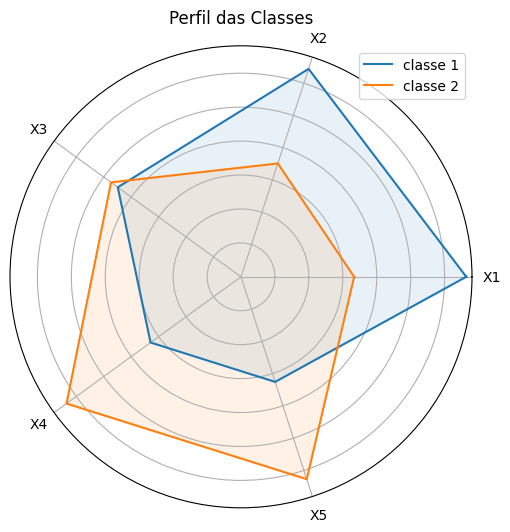

In [16]:
import numpy as np
import matplotlib.pyplot as plt

mean_values = users.groupby('classe').mean()

# Gráfico de radar
angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
for i, classe in enumerate(mean_values.index):
    values = mean_values.loc[classe].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, label=f'classe {classe}')
    ax.fill(angles, values, alpha=0.1)

ax.set_title('Perfil das Classes')
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(features)
plt.legend()
plt.show()

## g) Qual a probabilidade do i-ésimo usuário ser alocado ao cluster 1? Explique sua resposta deforma genérica e escolha um dos 1000 usuários para exemplificar.


A probabilidade do i-ésimo usuário, representado pelas features $\vec{x}_i = (x_{1i}, x_{2i}, x_{3i}, x_{4i}, x_{5i})$, ser alocado ao cluster 1 é dada pela posterior:

$$
P\left(C = 1 \mid \vec{x}_i\right) = \frac{P\left(\vec{x}_i \mid C\right) \cdot P\left(C = 1\right)}{P\left(\vec{x}_i\right)}
$$
$$
= P\left(C = 1 \mid \vec{x}_i\right) =
\frac{\prod_{j=1}^5 P\left(X_{j} = x_{ji} \mid C = 1\right) \cdot P\left(C = 1\right)}
{\prod_{j=1}^5 P\left(X_{j} = x_{ji} \mid C = 1\right) P\left(C = 1\right) + \prod_{j=1}^5 P\left(X_{j} = x_{ji} \mid C = 2\right) P\left(C = 2\right)}
$$
$$
= P\left(C = 1 \mid \vec{x}_i\right) =
\frac{ 0.42 \cdot \prod_{j=1}^5 P\left(X_{j} = x_{ji} \mid C = 1\right)}
{ 0.42 \cdot \prod_{j=1}^5 P\left(X_{j} = x_{ji} \mid C = 1\right)+  0.58 \cdot \prod_{j=1}^5 P\left(X_{j} = x_{ji} \mid C = 2\right)}
$$

Por exemplo, para o primeiro usuário do dataset, com os dados $\vec{x}_1 = (3, 1, 2, 3, 3)$, implementado com índice 0, teremos a probabilidade:

<!-- $$
\frac{ 0.42 \cdot P\left(X_{1} = 3 \mid C = 1\right) P\left(X_{2} = 1 \mid C = 1\right) P\left(X_{3} = 2 \mid C = 1\right) P\left(X_{4} = 3 \mid C = 1\right) P\left(X_{5} = 3 \mid C = 1\right)}
{ 0.42 \cdot  P\left(X_{1} = 3 \mid C = 1\right) P\left(X_{2} = 1 \mid C = 1\right) P\left(X_{3} = 2 \mid C = 1\right) P\left(X_{4} = 3 \mid C = 1\right) P\left(X_{5} = 3 \mid C = 1\right) +  0.58 \cdot P\left(X_{1} = 3 \mid C = 2\right) P\left(X_{2} = 1 \mid C = 2\right) P\left(X_{3} = 2 \mid C = 2\right) P\left(X_{4} = 3 \mid C = 2\right) P\left(X_{5} = 3 \mid C = 2\right)}
$$ -->

In [17]:
prob_xk_1 = np.prod([prob_x_given_class_1[users.iloc[0,i]-1,i] for i in range(n_features)])
prob_xk_2 = np.prod([prob_x_given_class_2[users.iloc[0,i]-1,i] for i in range(n_features)])
    
posterior_class_1 = prob_xk_1 * prior_class_1 / (prob_xk_1 * prior_class_1 + prob_xk_2 * prior_class_2)
posterior_class_1

0.03809471238762736

## h) Um usuário que votou 1,2,3,4,2 deveria ser alocado ao cluster 1 ou 2? Justifique.


A função ``predict_class`` retorna a classe com maior posterior. A partir dela, temos que o usuário vai para a classe 2.

In [18]:
predict_class(pd.Series([1,2,3,4,2]))

2

## i) Como você classificaria um usuário que votou 3,2,?,2,3? Isto é, o usuário não votou na feature número 3 (por exemplo, não deu seu voto para filmes de Romance). Explique.


Como as features são independentes entre si por suposição, não precisamos imputá-lo com base nas outras features. Para imputá-lo podemos apenas usar o valor mais frequente da feature X3, que é o 2, pela tabela de frequências abaixo:

In [19]:
# ocorrências de cada valor por feature
pd.DataFrame({
    'X1': users['X1'].value_counts(),
    'X2': users['X2'].value_counts(),
    'X3': users['X3'].value_counts(),
    'X4': users['X4'].value_counts(),
    'X5': users['X5'].value_counts()
})

,X1,X2,X3,X4,X5
1,292,304,283,396,419
2,138,127,331,167,153
3,234,238,192,177,165
4,336,331,194,260,263


Portanto, a classe desse usuário é:

In [20]:
user_questao_1i = pd.Series([3,2,2,2,3])
predict_class(user_questao_1i)

2

# Questão 2 Markov Chains
Um robô pode se mover pelos quadrados da figura abaixo. A cada unidade de tempo (minuto, por exemplo) o robô tenta se mover para um dos quadrados adjacentes ao que ocupa e escolhe uma dentre as possíveis ações: (a) mover para Norte: (b) mover para Sul: (c) mover para Leste: (d) mover para
Oeste. O robô não consegue enxergar a sua volta, então escolhe aleatoriamente uma dentre as 4 ações possíveis para só então fazer um movimento. Caso o robô tenha escolhido se mover na direção de um dos quadrados em rosa (os com tijolinhos na Figura 1) ou para fora da ambiente, ele colide com a
parede e permanece na mesma posição até a nova tentativa.

## 1. Construa a cadeia de Markov que representa o movimento do robô pelo ambiente, e mostre a matriz de transição de estados do sistema. Para facilitar a correção, indique claramente quais os estados do sistema e exemplifique indicando as probabilidades de transição para um movimento.


Para a modelagem do problema, usarei uma cadeia de markov com **12 estados**, um para cada coordenada acessível. O diagrama da cadeia pode ser visto abaixo. Em cada estado, estão indicados seu índice na matriz de transição e suas coordenadas no mapa.

<!-- ![Markov chain](markov_chain.png "Markov chain") -->

<img src="markov_chain.png" alt="Markov chain" style="height: 500px;"/>

A partir do diagrama, teremos a matriz de transição (os zeros foram substituidos por pontos para facilitar a visualização):

$$
P = 
\frac{1}{4}
 \begin{bmatrix}
 2 & 1 & \cdot & \cdot & 1 & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot \\
 1 & 1 & 1 & \cdot & \cdot & 1 & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot \\
 \cdot & 1 & 3 & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot \\
 \cdot & \cdot & \cdot & 2 & 1 & \cdot & 1 & \cdot & \cdot & \cdot & \cdot & \cdot \\
 1 & \cdot & \cdot & 1 & 1 & 1 & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot \\
 \cdot & 1 & \cdot & \cdot & 1 & 1 & \cdot & 1 & \cdot & \cdot & \cdot & \cdot \\
 \cdot & \cdot & \cdot & 1 & \cdot & \cdot & 3 & \cdot & \cdot & \cdot & \cdot & \cdot \\
 \cdot & \cdot & \cdot & \cdot & \cdot & 1 & \cdot & 1 & 1 & \cdot & 1 & \cdot \\
 \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & 1 & 2 & \cdot & \cdot & 1 \\
 \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & 3 & 1 & \cdot \\
 \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & 1 & \cdot & 1 & 1 & 1 \\
 \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & 1 & \cdot & 1 & 2 
\end{bmatrix}  
$$

<!-- $$
\frac{1}{4}
 \begin{bmatrix}
 2 & 1 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
 1 & 1 & 1 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
 0 & 1 & 3 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
 0 & 0 & 0 & 2 & 1 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
 1 & 0 & 0 & 1 & 1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
 0 & 1 & 0 & 0 & 1 & 1 & 0 & 1 & 0 & 0 & 0 & 0 \\
 0 & 0 & 0 & 1 & 0 & 0 & 3 & 0 & 0 & 0 & 0 & 0 \\
 0 & 0 & 0 & 0 & 0 & 1 & 0 & 1 & 1 & 0 & 1 & 0 \\
 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 2 & 0 & 0 & 1 \\
 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 3 & 1 & 0 \\
 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 1 & 1 & 1 \\
 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 1 & 2 
\end{bmatrix}  
$$ -->

## 2. Suponha que o robô inicia a sua caminhada no quadrado indicado na figura (quadrado (2, 1)). Qual a probabilidade do robô se encontrar no quadrado (1,3) vinte minutos após o início?


O vetor inicial $v^{(0)}$ indicará que o robô tem probabilidade 1 de estar na coordenada (2, 1) (estado 6).

$$
v^{(0)} = 
\begin{bmatrix}
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 
\end{bmatrix}
$$

Ao passar um minuto após o início, teremos o vetor de probabilidades:

$$
v^{(1)} = v^{(0)}P
$$

Dessa forma, para obter a probabilidade de estar no quadrado (1,3) (estado 10) após 20 minutos, basta pegarmos a probabilidade de índice 10 do vetor, calculado no código abaixo.

$$
v^{(20)} = v^{(0)}P^{20} = 
\begin{bmatrix}
0.10341275 \\0.08585108 \\0.07560636 \\0.17109472 \\0.1215212 \\0.08395218 \\0.20023806 \\0.04680055 \\0.03327895 \\0.02153419 \\0.02936998 \\0.02733998
\end{bmatrix}^{T}
$$

Portanto a probabilidade é $v^{(20)}_{10} = 0.02936998$

In [21]:
P = np.array([
    [2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 1, 0, 1, 0, 0, 0, 0, 0],
    [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2]
]) / 4

v_0 = np.array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

print("v_1 =", v_0 @ P)
print("\n\nv_20 =", v_0 @ np.linalg.matrix_power(P, 20))

v_1 = [0.   0.   0.   0.25 0.   0.   0.75 0.   0.   0.   0.   0.  ]


v_20 = [0.10341275 0.08585108 0.07560636 0.17109472 0.1215212  0.08395218
 0.20023806 0.04680055 0.03327895 0.02153419 0.02936998 0.02733998]


## 3. O robô está caminhando há muito tempo t → ∞. Onde você apostaria que o robô se encontra?

Para isso, precisamos achar a distribuição limite da cadeia de markov. Pode ser que essa distribuição não exista, então seria difícil apostar em algum estado. Por outro lado, caso a distribuição limite exista, podemos apostar no estado com maior probabilidade de se estar.

Sabemos que, se a distribuição limite existe, então ela é igual a estacionária. Se a cadeia for aperiódica e irredutível, ela terá distribuição limite. Se a cadeia for irredutivel, basta que tenha um self-loop para ser aperiódica.

Como todos os estados possuem setas saindo e entrando, não há sumidouros, logo a cadeia é irredutível. Há vários self-loops, logo a cadeia é aperiódica. Portanto, a distribuição limite existe e é igual à distribuição estacionária. 

Para resolver o problema, basta, então, encontrar a distribuição estacionária $\vec{\pi} = [\pi_0, ..., \pi_{11}]$:

$$\vec{\pi} = \vec{\pi} P $$

Ou seja, resolver o sistema linear:

$$ \vec{\pi}(P - I) = 0$$

Posso multiplicar ambos os lados por 4, para que a matriz do sistema fique com números inteiros:

$$ \vec{\pi}(4P - 4I) = 0$$

Então terei o sistema:

$$
\vec{\pi}\left(
 \begin{bmatrix}
 2     & 1     & \cdot & \cdot & 1     & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot \\
 1     & 1     & 1     & \cdot & \cdot & 1     & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot \\
 \cdot & 1     & 3     & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot \\
 \cdot & \cdot & \cdot & 2     & 1     & \cdot & 1     & \cdot & \cdot & \cdot & \cdot & \cdot \\
 1     & \cdot & \cdot & 1     & 1     & 1     & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot \\
 \cdot & 1     & \cdot & \cdot & 1     & 1     & \cdot & 1     & \cdot & \cdot & \cdot & \cdot \\
 \cdot & \cdot & \cdot & 1     & \cdot & \cdot & 3     & \cdot & \cdot & \cdot & \cdot & \cdot \\
 \cdot & \cdot & \cdot & \cdot & \cdot & 1     & \cdot & 1     & 1     & \cdot & 1     & \cdot \\
 \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & 1     & 2     & \cdot & \cdot & 1 \\
 \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & 3     & 1     & \cdot \\
 \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & 1     & \cdot & 1     & 1     & 1 \\
 \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & 1     & \cdot & 1     & 2 
\end{bmatrix} - 
 \begin{bmatrix}
 4     & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot \\
 \cdot & 4     & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot \\
 \cdot & \cdot & 4     & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot \\
 \cdot & \cdot & \cdot & 4     & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot \\
 \cdot & \cdot & \cdot & \cdot & 4     & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot \\
 \cdot & \cdot & \cdot & \cdot & \cdot & 4     & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot \\
 \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & 4     & \cdot & \cdot & \cdot & \cdot & \cdot \\
 \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & 4     & \cdot & \cdot & \cdot & \cdot \\
 \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & 4     & \cdot & \cdot & \cdot \\
 \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & 4     & \cdot & \cdot \\
 \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & 4     & \cdot \\
 \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & 4     
\end{bmatrix}\right)
= \begin{bmatrix}
0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
0 
\end{bmatrix}^{T}
$$

$$
\vec{\pi}
 \begin{bmatrix}
 -2    & 1     & \cdot & \cdot & 1     & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot \\
 1     & -3    & 1     & \cdot & \cdot & 1     & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot \\
 \cdot & 1     & -1    & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot \\
 \cdot & \cdot & \cdot & -2    & 1     & \cdot & 1     & \cdot & \cdot & \cdot & \cdot & \cdot \\
 1     & \cdot & \cdot & 1     & -3    & 1     & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot \\
 \cdot & 1     & \cdot & \cdot & 1     & -3    & \cdot & 1     & \cdot & \cdot & \cdot & \cdot \\
 \cdot & \cdot & \cdot & 1     & \cdot & \cdot & -1    & \cdot & \cdot & \cdot & \cdot & \cdot \\
 \cdot & \cdot & \cdot & \cdot & \cdot & 1     & \cdot & -3    & 1     & \cdot & 1     & \cdot \\
 \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & 1     & -2    & \cdot & \cdot & 1     \\
 \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & -1    & 1     & \cdot \\
 \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & 1     & \cdot & 1     & -3    & 1     \\
 \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & 1     & \cdot & 1     & -2    
 \end{bmatrix}  
= \begin{bmatrix}
0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
0 
\end{bmatrix}^{T}
$$

Mas sabemos que esse sistema irá ter infinitas soluções, portanto, temos que adicionar a restrição de que $\sum_i \pi_i = 1$. Farei isso, adicionando uma nova coluna, cheia de uns na matriz $(P - I)$ e uma coluna com 1 ao vetor de zeros no lado direito da equação.

Então usarei o numpy para resolver o sistema:

$$
\vec{\pi}
 \begin{bmatrix}
 -2    & 1     & \cdot & \cdot & 1     & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & 1 \\
 1     & -3    & 1     & \cdot & \cdot & 1     & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & 1 \\
 \cdot & 1     & -1    & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & 1 \\
 \cdot & \cdot & \cdot & -2    & 1     & \cdot & 1     & \cdot & \cdot & \cdot & \cdot & \cdot & 1 \\
 1     & \cdot & \cdot & 1     & -3    & 1     & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & 1 \\
 \cdot & 1     & \cdot & \cdot & 1     & -3    & \cdot & 1     & \cdot & \cdot & \cdot & \cdot & 1 \\
 \cdot & \cdot & \cdot & 1     & \cdot & \cdot & -1    & \cdot & \cdot & \cdot & \cdot & \cdot & 1 \\
 \cdot & \cdot & \cdot & \cdot & \cdot & 1     & \cdot & -3    & 1     & \cdot & 1     & \cdot & 1 \\
 \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & 1     & -2    & \cdot & \cdot & 1     & 1 \\
 \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & -1    & 1     & \cdot & 1 \\
 \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & 1     & \cdot & 1     & -3    & 1     & 1 \\
 \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & 1     & \cdot & 1     & -2    & 1
\end{bmatrix}  
= \begin{bmatrix}
0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
1
\end{bmatrix}^{T}
$$

In [22]:
A = np.concatenate([(4*P - 4*np.eye(12)), np.ones((12,1))], axis=1)
b = np.zeros((13,1))
b[-1] = 1.

pi = np.linalg.lstsq(np.transpose(A), b, rcond=None)[0]
pi

array([[0.08333333],
       [0.08333333],
       [0.08333333],
       [0.08333333],
       [0.08333333],
       [0.08333333],
       [0.08333333],
       [0.08333333],
       [0.08333333],
       [0.08333333],
       [0.08333333],
       [0.08333333]])

A solução é que quando o tempo tende ao infinito, todos os **estados têm probabilidade igual** do robô se encontrar nele. Logo, apostaria em qualquer um.

## 4. Quantos minutos em média leva para o robô retornar ao ponto de partida? É preciso pensar um pouquinho. Proponha uma possível solução a ser discutida na próxima aula. (Para a próxima aula, não precisa resolver esse item, mas será essencial mostrar que você pensou numa solução para apresentar)

Podemos pensar no problema como uma rede de filas. Imaginemos que o robô estar no estado inicial é equivalente a estar em uma fila esperando para ser atendido. Ao sair do estado inicial, ele estará sendo servido. Ao voltar para o estado inicial, ele terminou de ser servido e entra na fila novamente (rede de fila fechada).

Nesse caso, penso que podemos ter duas interpretações:

1. Ao voltar para o estado inicial, consideramos que ele sairá dele logo no próximo minuto. Assim, temos que alterar a cadeia, removendo o self-loop e colocando apenas uma transição do estado 6 para o 3 com probabilidade 1. Dessa forma, estamos apenas interessados no tempo de serviço para o robô, ou seja, quanto tempo em média ele passa fora do estado inicial.
2. Ao voltar para o estado inicial, consideramos que ele pode se manter ali com probabilidade 3/4, como especificado originalmente pelo problema. Assim, ao continuar no estado inicial, será considerado que demorou 0 minutos para ele retornar, o que afetará a média total.

No primeiro caso, podemos considerar que temos um sistema fechado em batch, em que não há tempo de espera na fila até o robô ser servido de novo (zero think time). Logo, pela lei de Little, temos:

$$N = X \cdot \mathbb{E}[T]$$

Onde N é o número de jobs, X é o throughput do sistema e $\mathbb{E}[T]$ é o tempo médio no sistema. 

Nesse caso, $N = 1$ pois só temos um robô. O throughput é a taxa na qual o robô volta para o estado inicial, ou seja, é a probabilidade do robô estar no estado inicial $X = 0.083...$. Então, o tempo médio de retorno é:

$$\mathbb{E}[T] = \frac{N}{X} = \frac{1}{0.083...} = 12$$

Já no segundo caso, há um tempo em que o robô se mantém no estado inicial. Então o tempo médio no sistema é
$$\mathbb{E}[T] = \mathbb{E}[R] + \mathbb{E}[Z]$$

Onde $\mathbb{E}[R]$ é o tempo gasto no estado inicial (think time) e $\mathbb{E}[Z]$ é o tempo de resposta do sistema. Logo, pela lei de Little:

$$N = X \cdot \mathbb{E}[T] = X \cdot (\mathbb{E}[R] + \mathbb{E}[Z]) = X \cdot \mathbb{E}[R] + X \cdot \mathbb{E}[Z]$$
$$ \mathbb{E}[Z] = \frac{N - X \cdot \mathbb{E}[R]}{X}$$

O tempo gasto no estado inicial é o inverso da probabilidade do robô se manter lá $\mathbb{E}[R] = \frac{1}{3/4} = \frac{4}{3}$, logo:

$$ \mathbb{E}[Z] = \frac{1 - 0.083... \cdot \frac{4}{3}}{0.083...} = 10.6...$$